In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle
from sklearn.pipeline import Pipeline


In [2]:
matches = pd.read_csv('IPL_Matches_2008_2022.csv')
delivery = pd.read_csv('IPL_Ball_by_Ball_2008_2022.csv')

# Dataset Creation

In [3]:
matches.head(2)

,ID,City,Date,Season,MatchNumber,Team1,Team2,Venue,TossWinner,TossDecision,SuperOver,WinningTeam,WonBy,Margin,method,Player_of_Match,Team1Players,Team2Players,Umpire1,Umpire2
0,1312200,Ahmedabad,2022-05-29,2022,Final,Rajasthan Royals,Gujarat Titans,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,bat,N,Gujarat Titans,Wickets,7.0,NaN,HH Pandya,"['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...","['WP Saha', 'Shubman Gill', 'MS Wade', 'HH Pan...",CB Gaffaney,Nitin Menon
1,1312199,Ahmedabad,2022-05-27,2022,Qualifier 2,Royal Challengers Bangalore,Rajasthan Royals,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,field,N,Rajasthan Royals,Wickets,7.0,NaN,JC Buttler,"['V Kohli', 'F du Plessis', 'RM Patidar', 'GJ ...","['YBK Jaiswal', 'JC Buttler', 'SV Samson', 'D ...",CB Gaffaney,Nitin Menon


In [4]:
delivery.head(2)

,ID,innings,overs,ballnumber,batter,bowler,non-striker,extra_type,batsman_run,extras_run,total_run,non_boundary,isWicketDelivery,player_out,kind,fielders_involved,BattingTeam
0,1312200,1,0,1,YBK Jaiswal,Mohammed Shami,JC Buttler,NaN,0,0,0,0,0,NaN,NaN,NaN,Rajasthan Royals
1,1312200,1,0,2,YBK Jaiswal,Mohammed Shami,JC Buttler,legbyes,0,1,1,0,0,NaN,NaN,NaN,Rajasthan Royals


##LE

In [5]:
# # prompt: apply label encoder on ID column

# # Assuming 'matches' DataFrame is already loaded as shown in the previous code

# le = LabelEncoder()
# matches['ID'] = le.fit_transform(matches['ID'])
# delivery['ID'] = le.transform(delivery['ID'])

In [6]:
# matches[matches['ID'] == 1]

In [7]:
# delivery[delivery['ID'] == 1].head(124)

##Feature extract

In [8]:
matches.columns

Index(['ID', 'City', 'Date', 'Season', 'MatchNumber', 'Team1', 'Team2',
       'Venue', 'TossWinner', 'TossDecision', 'SuperOver', 'WinningTeam',
       'WonBy', 'Margin', 'method', 'Player_of_Match', 'Team1Players',
       'Team2Players', 'Umpire1', 'Umpire2'],
      dtype='object')

In [9]:
matches = matches[['ID','City','WinningTeam','Team1','Team2']]

In [10]:
delivery.columns

Index(['ID', 'innings', 'overs', 'ballnumber', 'batter', 'bowler',
       'non-striker', 'extra_type', 'batsman_run', 'extras_run', 'total_run',
       'non_boundary', 'isWicketDelivery', 'player_out', 'kind',
       'fielders_involved', 'BattingTeam'],
      dtype='object')

In [11]:
delivery = delivery[['ID','innings','overs','ballnumber','total_run','player_out','isWicketDelivery','BattingTeam']]

##inning 1 runs of matches like target_runs added -> match_df

In [12]:
# total_runs per inning
total_score_df = delivery.groupby(['ID','innings']).sum()['total_run'].reset_index()
total_score_df.head(2)

,ID,innings,total_run
0,335982,1,222
1,335982,2,82


In [13]:
# getting for only first inning
total_score_df = total_score_df[total_score_df['innings'] == 1]
total_score_df.head(2)

,ID,innings,total_run
0,335982,1,222
2,335983,1,240


In [14]:
# adding this total_run column & matches columns to new match_df
match_df = matches.merge(total_score_df[['ID','total_run']],left_on='ID',right_on='ID')
match_df.head(2)

,ID,City,WinningTeam,Team1,Team2,total_run
0,1312200,Ahmedabad,Gujarat Titans,Rajasthan Royals,Gujarat Titans,130
1,1312199,Ahmedabad,Rajasthan Royals,Royal Challengers Bangalore,Rajasthan Royals,157


##match_df + delivery => delivery_df

In [15]:
delivery_df = match_df.merge(delivery,on='ID')

##teams & teamsname correction

In [16]:
match_df['Team1'].unique()

array(['Rajasthan Royals', 'Royal Challengers Bangalore',
       'Sunrisers Hyderabad', 'Delhi Capitals', 'Chennai Super Kings',
       'Gujarat Titans', 'Lucknow Super Giants', 'Kolkata Knight Riders',
       'Punjab Kings', 'Mumbai Indians', 'Kings XI Punjab',
       'Delhi Daredevils', 'Rising Pune Supergiant', 'Gujarat Lions',
       'Rising Pune Supergiants', 'Pune Warriors', 'Deccan Chargers',
       'Kochi Tuskers Kerala'], dtype=object)

In [17]:
# changing name of teams which exists with different name
match_df['Team1'] = match_df['Team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['Team2'] = match_df['Team2'].str.replace('Delhi Daredevils','Delhi Capitals')

match_df['Team1'] = match_df['Team1'].str.replace('Kings XI Punjab','Punjab Kings')
match_df['Team2'] = match_df['Team2'].str.replace('Kings XI Punjab','Punjab Kings')

match_df['Team1'] = match_df['Team1'].str.replace('Gujarat Lions','Gujarat Titans')
match_df['Team2'] = match_df['Team2'].str.replace('Gujarat Lions','Gujarat Titans')

match_df['Team1'] = match_df['Team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['Team2'] = match_df['Team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

#removing old teams which are not playing currently
teams = ['Rajasthan Royals', 'Royal Challengers Bangalore',
       'Sunrisers Hyderabad', 'Delhi Capitals', 'Chennai Super Kings',
       'Gujarat Titans', 'Lucknow Super Giants', 'Kolkata Knight Riders',
       'Punjab Kings', 'Mumbai Indians']

match_df = match_df[(match_df['Team1'].isin(teams)) & (match_df['Team2'].isin(teams))]

# In delivery_df
delivery_df = delivery_df[(delivery_df['BattingTeam'].isin(teams))]

##NaN in delivery_df

In [18]:
delivery_df.isna().sum()

ID                       0
City                 10333
WinningTeam            186
Team1                    0
Team2                    0
total_run_x              0
innings                  0
overs                    0
ballnumber               0
total_run_y              0
player_out          153590
isWicketDelivery         0
BattingTeam              0
dtype: int64

In [19]:
delivery_df = delivery_df.dropna(subset=['City'])
delivery_df = delivery_df.dropna(subset=['WinningTeam'])
delivery_df['player_out'] = delivery_df['player_out'].fillna('0') # means no wicket on this ball

##delivery_df for only inning=2 for current batting team prediction

In [20]:
# taking data for only second innings
delivery_df = delivery_df[delivery_df['innings'] == 2]

##creating some columns

###BallingTeam

In [21]:
# now i need one column called 'bowling_team' which calculated by if batting team == Team1 return Team2 else Team1
delivery_df['BallingTeam'] = np.where(delivery_df['BattingTeam'] == delivery_df['Team1'], delivery_df['Team2'], delivery_df['Team1'])


###current_score : current runs on each ball

In [22]:
# calculating current score on each ball
delivery_df['current_score'] = delivery_df.groupby('ID')['total_run_y'].cumsum()

###runs_left : how much runs left to win = target - current

In [23]:
# calculating runs_left to win BattingTeam
delivery_df['runs_left'] = delivery_df['total_run_x'] - delivery_df['current_score']

In [24]:
# prompt: somewhere runs_left column gives -ve values, so i want to find where is it

delivery_df[delivery_df['runs_left'] < 0].head(2)

# it is last ball of game where like team need 3 runs and player hit 6 so team get 6 runs at that time runs_left is giving -ve score
# but it can be helpful to denote winning to model

,ID,City,WinningTeam,Team1,Team2,total_run_x,innings,overs,ballnumber,total_run_y,player_out,isWicketDelivery,BattingTeam,BallingTeam,current_score,runs_left
232,1312200,Ahmedabad,Gujarat Titans,Rajasthan Royals,Gujarat Titans,130,2,18,1,6,0,0,Gujarat Titans,Rajasthan Royals,133,-3
468,1312199,Ahmedabad,Rajasthan Royals,Royal Challengers Bangalore,Rajasthan Royals,157,2,18,1,6,0,0,Rajasthan Royals,Royal Challengers Bangalore,161,-4


In [25]:
# # prompt: remove this columns where runs_left have -ve values

# delivery_df = delivery_df[delivery_df['runs_left'] >= 0]


###ballnumbercorrection
###balls_left : how many balls left from 20*6

In [26]:
delivery_df['ballnumber'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [27]:
# Drop rows where ballnumber > 6
delivery_df = delivery_df[delivery_df['ballnumber'] <= 6]


In [28]:
# calculating balls_left by (total_balls+6) - (over*6 + current_ball_number)
delivery_df['balls_left'] = 120 - (delivery_df['overs']*6 + delivery_df['ballnumber'])

###wicket_left out of 10

In [29]:
# calculating wickets_left by 2 ways

In [30]:
# first way
delivery_df['isWicketDelivery'].unique()

array([0, 1])

In [31]:
delivery_df['wicket_left'] = 10 - delivery_df.groupby('ID')['isWicketDelivery'].cumsum()

In [32]:
# second way
delivery_df['player_out'] = delivery_df['player_out'].apply(lambda x: x if x == '0' else '1') # name assigned to '1'
delivery_df['player_out'] = delivery_df['player_out'].astype('int')
wickets = delivery_df.groupby('ID')['player_out'].cumsum()
delivery_df['wickets'] = 10 - wickets

In [33]:
delivery_df.shape

(69914, 19)

In [34]:
# Comparing 'wickets' and 'wicket_left' columns
comparison_result = delivery_df['wickets'] == delivery_df['wicket_left']
print(comparison_result.value_counts())


True    69914
Name: count, dtype: int64


In [35]:
# so both method is same to find left wickets

###run_rates
####crr : current runrate<br>
####rrr : required runrate

In [36]:
# rrr would be infinite value because of last ball-> balls_left=0 and so that rrr will be infinity
# crr would be infinite value because of first ball-> balls_left=120 and so that crr will be infinity

# remove row of last ball
delivery_df = delivery_df[delivery_df['balls_left'] != 0]
# remove row of first ball
delivery_df = delivery_df[delivery_df['balls_left'] != 120]

In [37]:
# current_run_rate
# crr = current_runs / current_overs
delivery_df['crr'] = delivery_df['current_score'] * 6 / (120 - delivery_df['balls_left'])

In [38]:
# required_run_rate
# current rrr = (total_target_runs - current_runs) / (total_overs - current_over)
delivery_df['rrr'] = (delivery_df['runs_left'] * 6) / delivery_df['balls_left']

###result: in inning 2 - win(1) if BattingTeam == WinningTeam
because we are making prediction for second team

In [39]:
# calculating result because here data is of inning 2 so batting team is can be WinningTeam or not
delivery_df['result'] = np.where(delivery_df['WinningTeam'] == delivery_df['BattingTeam'], 1, 0)
delivery_df.head()

,ID,City,WinningTeam,Team1,Team2,total_run_x,innings,overs,ballnumber,total_run_y,...,BattingTeam,BallingTeam,current_score,runs_left,balls_left,wicket_left,wickets,crr,rrr,result
120,1312200,Ahmedabad,Gujarat Titans,Rajasthan Royals,Gujarat Titans,130,2,0,1,0,...,Gujarat Titans,Rajasthan Royals,0,130,119,10,10,0.0,6.554622,1
121,1312200,Ahmedabad,Gujarat Titans,Rajasthan Royals,Gujarat Titans,130,2,0,2,0,...,Gujarat Titans,Rajasthan Royals,0,130,118,10,10,0.0,6.610169,1
122,1312200,Ahmedabad,Gujarat Titans,Rajasthan Royals,Gujarat Titans,130,2,0,3,1,...,Gujarat Titans,Rajasthan Royals,1,129,117,10,10,2.0,6.615385,1
123,1312200,Ahmedabad,Gujarat Titans,Rajasthan Royals,Gujarat Titans,130,2,0,4,0,...,Gujarat Titans,Rajasthan Royals,1,129,116,10,10,1.5,6.672414,1
124,1312200,Ahmedabad,Gujarat Titans,Rajasthan Royals,Gujarat Titans,130,2,0,5,0,...,Gujarat Titans,Rajasthan Royals,1,129,115,10,10,1.2,6.730435,1


#final_df : by extracting needed column and shuffling rows for model from delivery_df

In [40]:
# creating final df using needed columns
final_df = delivery_df[['BattingTeam','BallingTeam','City','runs_left','balls_left','wicket_left','total_run_x','crr','rrr','result']]
final_df.head(2)

,BattingTeam,BallingTeam,City,runs_left,balls_left,wicket_left,total_run_x,crr,rrr,result
120,Gujarat Titans,Rajasthan Royals,Ahmedabad,130,119,10,130,0.0,6.554622,1
121,Gujarat Titans,Rajasthan Royals,Ahmedabad,130,118,10,130,0.0,6.610169,1


In [41]:
# here all data are arranged ball by ball so it can create bias, for this we are shuffling all rows
final_df = final_df.sample(final_df.shape[0])
final_df.head(2)

,BattingTeam,BallingTeam,City,runs_left,balls_left,wicket_left,total_run_x,crr,rrr,result
158393,Mumbai Indians,Deccan Chargers,Mumbai,99,117,9,100,2.000000,5.076923,1
9611,Kolkata Knight Riders,Gujarat Titans,Navi Mumbai,48,28,3,156,7.043478,10.285714,0


#model creation using pipeline and Logistic regression

In [42]:
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [43]:
trf1 = ColumnTransformer([
    ('ohe',OneHotEncoder(sparse_output=False,drop='first'),['BattingTeam','BallingTeam','City'])
],remainder='passthrough')

In [44]:
pipe = Pipeline(steps=[
        ('step1',trf1),
        ('step2',LogisticRegression(solver='liblinear'))
    ])

In [45]:
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.829028555029416


In [46]:
pipe.predict_proba(X_test)[10]

array([0.9985311, 0.0014689])

In [47]:
pipe.predict(X_test)[10]

0

#visualization

In [48]:
final_df.head()

,BattingTeam,BallingTeam,City,runs_left,balls_left,wicket_left,total_run_x,crr,rrr,result
158393,Mumbai Indians,Deccan Chargers,Mumbai,99,117,9,100,2.000000,5.076923,1
9611,Kolkata Knight Riders,Gujarat Titans,Navi Mumbai,48,28,3,156,7.043478,10.285714,0
169303,Rajasthan Royals,Mumbai Indians,Mumbai,45,65,10,133,9.600000,4.153846,1
181150,Royal Challengers Bangalore,Chennai Super Kings,Chennai,165,109,8,183,9.818182,9.082569,0
18110,Kolkata Knight Riders,Chennai Super Kings,Dubai,93,48,8,192,8.250000,11.625000,0


In [49]:
def match_summary(row):
    print("Batting Team : " + row['BattingTeam'] + " \nBowling Team : " + row['BallingTeam'] + " \nTarget : " + str(row['total_run_x']))


In [50]:
match_summary(X_test.iloc[4])

Batting Team : Kolkata Knight Riders 
Bowling Team : Mumbai Indians 
Target : 141


In [51]:
l = delivery_df['ID'].unique()

In [52]:
# choose id from here to visualize
np.sort(l)

array([ 335982,  335985,  335986,  335987,  335989,  335990,  335991,
        335992,  335993,  335996,  335997,  335998,  336000,  336002,
        336003,  336005,  336008,  336009,  336010,  336011,  336012,
        336015,  336018,  336019,  336021,  336023,  336025,  336027,
        336028,  336029,  336033,  336035,  336036,  336037,  336039,
        336040,  392181,  392182,  392185,  392186,  392188,  392189,
        392190,  392192,  392195,  392197,  392198,  392199,  392200,
        392202,  392203,  392205,  392208,  392212,  392213,  392217,
        392218,  392220,  392221,  392222,  392224,  392225,  392227,
        392230,  392231,  392232,  392233,  392238,  392239,  419107,
        419109,  419110,  419112,  419113,  419115,  419116,  419118,
        419119,  419121,  419122,  419123,  419125,  419126,  419128,
        419129,  419131,  419132,  419133,  419134,  419136,  419137,
        419140,  419142,  419143,  419148,  419150,  419151,  419153,
        419154,  419

In [53]:
def match_summary(row):
    print("Batting Team : " + row['BattingTeam'] + " \nBowling Team : " + row['BallingTeam'] + " \nTarget : " + str(row['total_run_x']))

In [54]:
def match_progression(x_df,match_id,pipe):

    t_df = x_df[x_df['ID'] == match_id] # fetching data of given id

    t_df = t_df[(t_df['ballnumber'] == 6)] # row of last ball of over

    temp_df = t_df[['BattingTeam','BallingTeam','City','runs_left','balls_left','wicket_left','total_run_x','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0] # row of last ball removed
    result = pipe.predict_proba(temp_df) # predict

    temp_df['lose'] = np.round(result.T[0]*100,1) # roundoff by 1 and fetching lose prob
    temp_df['win'] = np.round(result.T[1]*100,1) # roundoff by 1 and fetching win prob
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1) # 1 to 19 overs

    target = temp_df['total_run_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_in_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wicket_left'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]

    match_summary(temp_df.iloc[-1])
    actual_result = t_df['result']
    print("Actual Result : ",actual_result.values[0])
    print("Prediction : ",pipe.predict(temp_df)[0])
    temp_df = temp_df[['end_of_over','runs_in_over','wickets_in_over','win','lose']]
    return temp_df,target


In [55]:
temp_df,target = match_progression(delivery_df,336028,pipe)
temp_df

Batting Team : Mumbai Indians 
Bowling Team : Kings XI Punjab 
Target : 189
Actual Result :  0
Prediction :  0


,end_of_over,runs_in_over,wickets_in_over,win,lose
215720,1,9,0,34.1,65.9
215729,2,21,0,53.6,46.4
215736,3,6,1,42.4,57.6
215742,4,4,0,41.8,58.2
215748,5,16,0,56.7,43.3
215754,6,12,0,66.2,33.8
215760,7,6,0,67.7,32.3
215766,8,7,0,70.3,29.7
215772,9,2,1,52.9,47.1
215778,10,7,0,55.0,45.0


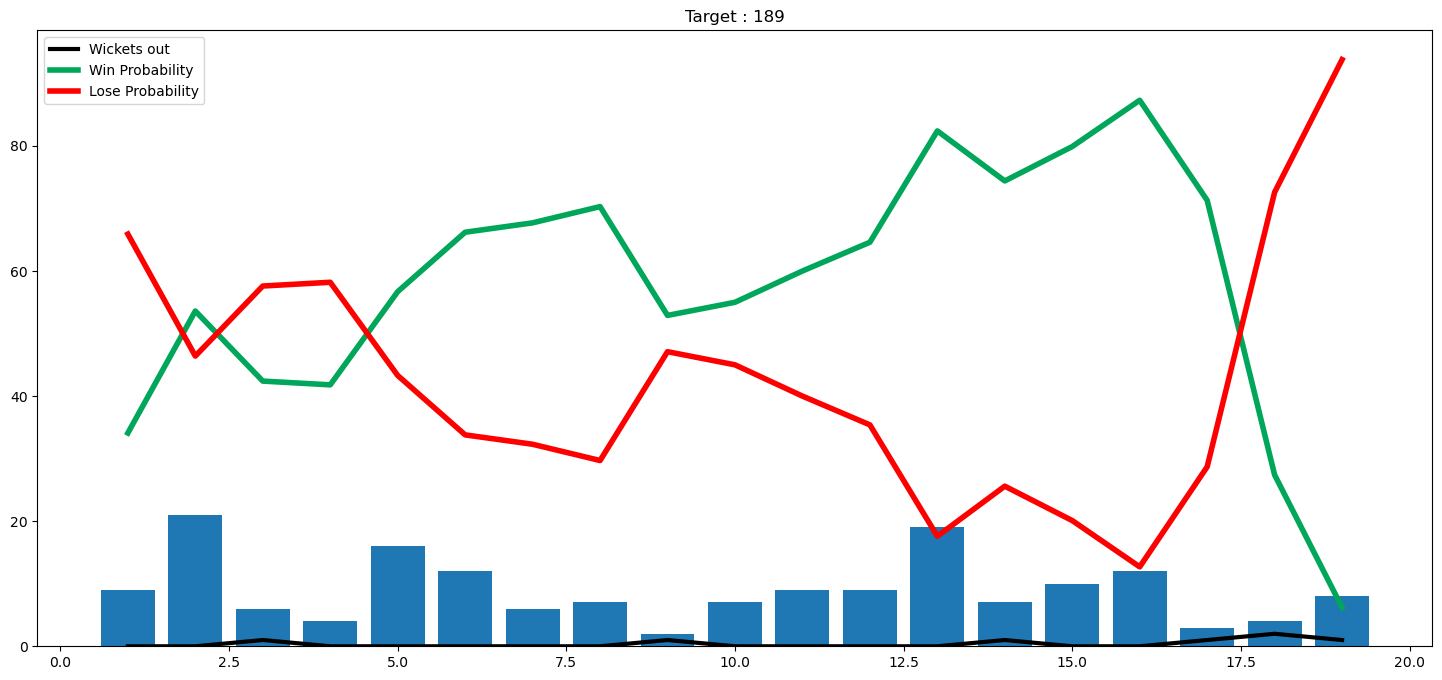

In [57]:
# Corrected plotting code
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.plot(temp_df['end_of_over'].to_numpy(), temp_df['wickets_in_over'].to_numpy(), color='black', linewidth=3)
plt.plot(temp_df['end_of_over'].to_numpy(), temp_df['win'].to_numpy(), color='#00a65a', linewidth=4)
plt.plot(temp_df['end_of_over'].to_numpy(), temp_df['lose'].to_numpy(), color='red', linewidth=4)
plt.bar(temp_df['end_of_over'].to_numpy(), temp_df['runs_in_over'].to_numpy())
plt.title('Target : ' + str(target))
plt.legend(["Wickets out", "Win Probability", "Lose Probability"])
plt.show()

In [58]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(18,8))
# plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='black',linewidth=3)
# plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
# plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
# plt.bar(temp_df['end_of_over'],temp_df['runs_in_over'])
# plt.title('Target : ' + str(target))
# plt.legend(["Wickets out","Win Probability","Lose Probability"])
# plt.show()

In [ ]:
pickle.dump(pipe,open('model.pkl','wb'))

In [60]:
final_df['City'].unique()

array(['Mumbai', 'Navi Mumbai', 'Chennai', 'Dubai', 'Jaipur', 'Bangalore',
       'Delhi', 'Chandigarh', 'Ahmedabad', 'Kimberley', 'Kolkata',
       'Abu Dhabi', 'Indore', 'Bengaluru', 'Bloemfontein', 'Cuttack',
       'Dharamsala', 'Ranchi', 'Hyderabad', 'Visakhapatnam', 'Sharjah',
       'Port Elizabeth', 'Pune', 'Kanpur', 'Durban', 'Nagpur',
       'Johannesburg', 'Centurion', 'East London', 'Cape Town', 'Kochi',
       'Rajkot', 'Raipur'], dtype=object)

In [61]:
final_df['BattingTeam'].unique()

array(['Mumbai Indians', 'Kolkata Knight Riders', 'Rajasthan Royals',
       'Royal Challengers Bangalore', 'Lucknow Super Giants',
       'Chennai Super Kings', 'Delhi Capitals', 'Sunrisers Hyderabad',
       'Gujarat Titans', 'Punjab Kings'], dtype=object)

In [62]:
final_df.columns

Index(['BattingTeam', 'BallingTeam', 'City', 'runs_left', 'balls_left',
       'wicket_left', 'total_run_x', 'crr', 'rrr', 'result'],
      dtype='object')